# 06.1w: Optimal Projection Sky Map (Float64)

**Goal:** Visualize the 13 degenerate black hole clusters with float64 precision to collapse identical embeddings to single pixels.

The 13 unique black hole vectors (with ~2,100 degenerate tokens total) should collapse to exactly 13 distinct pixels. We want to see all ~2,100 points plotted, but only 13 visible red dots.

**Key difference from 06.1v:** 
- Identify black holes by **actual degeneracy** (np.unique) not distance threshold
- Use float64 for all intermediate computations
- Should achieve perfect collapse: 2,100 tokens → 13 pixels

## Parameters

In [13]:
TENSOR_DIR = "../data/tensors"
GAMMA_FILE = "gamma_qwen3_4b_instruct_2507.safetensors"
CENTROID_FILE = "gamma_centroid_mu.safetensors"
OPTIMAL_BASIS_FILE = "optimal_projection_basis.safetensors"
BH_DISTANCES_FILE = "black_hole_distances_qwen3_4b_instruct_2507.safetensors"

# Viewing direction
HEADING = 0

# Zoom: centered on black holes
CENTER_LON = 145.2
CENTER_LAT = 44.9
ANGULAR_RADIUS = 20

# Zone boundaries
BLACK_HOLE_R = 1e-4
CUCKOO_R = 1e-3
EXCLUSION_R = 1e-2

# Visualization
POINT_SIZE = 3
POINT_ALPHA = 1.0
FIGURE_DPI = 100

## Imports

In [14]:
import torch
import numpy as np
from safetensors.torch import load_file
from pathlib import Path
import matplotlib.pyplot as plt
from collections import defaultdict

print("Imports loaded successfully.")

Imports loaded successfully.


## Step 1: Load Data and Upcast to Float64

In [15]:
data_dir = Path(TENSOR_DIR)

print("Loading data...")
gamma = load_file(data_dir / GAMMA_FILE)['gamma'].to(torch.float64)
cloud_centroid = load_file(data_dir / CENTROID_FILE)['mu'].to(torch.float64)

optimal_basis_data = load_file(data_dir / OPTIMAL_BASIS_FILE)
north_vector = optimal_basis_data['north_vector'].to(torch.float64)
meridian_vector = optimal_basis_data['meridian_vector'].to(torch.float64)
equinox_vector = optimal_basis_data['equinox_vector'].to(torch.float64)
angular_extent = optimal_basis_data['angular_extent'].item()

distances_from_bh = load_file(data_dir / BH_DISTANCES_FILE)['distances']

N, d = gamma.shape
print(f"Loaded gamma: {gamma.shape}, dtype: {gamma.dtype}")
print(f"Cloud centroid dtype: {cloud_centroid.dtype}")
print(f"Basis vectors dtype: {north_vector.dtype}")
print(f"Optimal angular extent: {angular_extent:.2f} square degrees")

Loading data...
Loaded gamma: torch.Size([151936, 2560]), dtype: torch.float64
Cloud centroid dtype: torch.float64
Basis vectors dtype: torch.float64
Optimal angular extent: 0.60 square degrees


## Step 2: Identify Degenerate Black Holes

Use np.unique to find bit-for-bit identical embeddings (the 13 degenerate clusters).

In [16]:
from collections import defaultdict

print("Finding degenerate embeddings...")
gamma_np = gamma.cpu().numpy()

# Find unique vectors
unique_vecs, inverse_indices, counts = np.unique(
    gamma_np, 
    axis=0, 
    return_inverse=True, 
    return_counts=True
)

# Build clusters
clusters = defaultdict(list)
for token_id, unique_idx in enumerate(inverse_indices):
    clusters[unique_idx].append(token_id)

# Filter to degenerate clusters (size > 1)
degenerate_clusters = {idx: tokens for idx, tokens in clusters.items() if len(tokens) > 1}

# Sort by size
sorted_clusters = sorted(degenerate_clusters.items(), key=lambda x: len(x[1]), reverse=True)

# Extract top 13 clusters (the primordial black holes)
black_hole_token_ids = []
for unique_idx, token_ids in sorted_clusters[:13]:
    black_hole_token_ids.extend(token_ids)

black_hole_token_ids = sorted(black_hole_token_ids)

# Create mask
black_hole_mask = torch.zeros(N, dtype=torch.bool)
black_hole_mask[black_hole_token_ids] = True

# For comparison, also compute distance-based zones for cuckoos/exclusion
gamma_torch = torch.from_numpy(gamma_np).to(torch.float64)
black_hole_embeddings = gamma_torch[black_hole_token_ids]
bh_centroid = black_hole_embeddings.mean(dim=0)
distances_from_bh = torch.norm(gamma_torch - bh_centroid, dim=1)

cuckoo_mask = (distances_from_bh > BLACK_HOLE_R) & (distances_from_bh <= CUCKOO_R)
exclusion_mask = (distances_from_bh > CUCKOO_R) & (distances_from_bh <= EXCLUSION_R)
bulk_mask = ~(black_hole_mask | cuckoo_mask | exclusion_mask)

n_black_holes = black_hole_mask.sum().item()
n_cuckoos = cuckoo_mask.sum().item()
n_exclusion = exclusion_mask.sum().item()
n_bulk = bulk_mask.sum().item()

print(f"\nDegenerate clusters found: {len(degenerate_clusters)}")
print(f"Top 13 clusters (primordial black holes):")
for i, (unique_idx, token_ids) in enumerate(sorted_clusters[:13], 1):
    print(f"  Cluster {i}: {len(token_ids)} tokens")
    
print(f"\nZone populations:")
print(f"  Black holes (degenerate): {n_black_holes:,}")
print(f"  Cuckoos: {n_cuckoos:,}")
print(f"  Exclusion zone: {n_exclusion:,}")
print(f"  Bulk: {n_bulk:,}")

Finding degenerate embeddings...

Degenerate clusters found: 13
Top 13 clusters (primordial black holes):
  Cluster 1: 814 tokens
  Cluster 2: 704 tokens
  Cluster 3: 306 tokens
  Cluster 4: 228 tokens
  Cluster 5: 11 tokens
  Cluster 6: 10 tokens
  Cluster 7: 6 tokens
  Cluster 8: 5 tokens
  Cluster 9: 4 tokens
  Cluster 10: 4 tokens
  Cluster 11: 3 tokens
  Cluster 12: 3 tokens
  Cluster 13: 2 tokens

Zone populations:
  Black holes (degenerate): 2,100
  Cuckoos: 27
  Exclusion zone: 11
  Bulk: 149,798


## Step 3: Project to Spherical Coordinates (Float64)

In [17]:
print("\nCentering at cloud centroid (float64)...")
gamma_prime = gamma - cloud_centroid

print("Projecting onto optimal basis (float64)...")
x = gamma_prime @ meridian_vector
y = gamma_prime @ equinox_vector
z = gamma_prime @ north_vector

print("Converting to spherical coordinates (float64)...")
r = torch.sqrt(x**2 + y**2 + z**2)
theta_rad = torch.asin(torch.clamp(z / r, -1, 1))
theta_deg = torch.rad2deg(theta_rad)
phi_rad = torch.atan2(y, x)
phi_deg = torch.rad2deg(phi_rad)

print(f"\nIntermediate computation dtype: {theta_deg.dtype}")
print(f"Latitude statistics (before CDF flattening):")
print(f"  Mean: {theta_deg.mean().item():.10f}°")
print(f"  Std: {theta_deg.std().item():.10f}°")


Centering at cloud centroid (float64)...
Projecting onto optimal basis (float64)...
Converting to spherical coordinates (float64)...

Intermediate computation dtype: torch.float64
Latitude statistics (before CDF flattening):
  Mean: 0.7566681842°
  Std: 38.9701737531°


## Step 4: Apply Tie-Aware CDF Flattening (Float64)

Preserve degeneracy: tokens with identical theta get identical flattened latitude.

In [18]:
print("\nApplying tie-aware CDF flattening (float64)...")

# Sort by theta
theta_sorted, sort_indices = torch.sort(theta_deg)

# Find unique theta values and their inverse mapping
unique_theta, inverse_indices = torch.unique(theta_sorted, return_inverse=True)

# Assign CDF values based on unique theta values (preserves ties)
# For each unique theta, assign the average rank of all tokens with that theta
n_unique = len(unique_theta)
cdf_values_unique = torch.linspace(0, 1, n_unique, dtype=torch.float64)

# Map back to all tokens via inverse indices
cdf_values_sorted = cdf_values_unique[inverse_indices]

# Map CDF to [-90°, +90°]
theta_flat_sorted = 90.0 * (2.0 * cdf_values_sorted - 1.0)

# Unsort
theta_flat = torch.zeros_like(theta_deg)
theta_flat[sort_indices] = theta_flat_sorted

print(f"Flattened latitude dtype: {theta_flat.dtype}")
print(f"Number of unique theta values: {n_unique:,}")
print(f"Number of unique flattened values: {len(torch.unique(theta_flat)):,}")


Applying tie-aware CDF flattening (float64)...
Flattened latitude dtype: torch.float64
Number of unique theta values: 149,849
Number of unique flattened values: 149,849


## Step 5: Apply Heading Rotation

In [19]:
phi_rotated = phi_deg - HEADING
phi_rotated = torch.where(phi_rotated > 180, phi_rotated - 360, phi_rotated)
phi_rotated = torch.where(phi_rotated < -180, phi_rotated + 360, phi_rotated)

print(f"Applied heading rotation: {HEADING}°")

Applied heading rotation: 0°


## Step 6: Check Black Hole Degeneracy

Let's verify that degenerate black holes now have identical coordinates in float64.

In [20]:
# Extract black hole coordinates
bh_lons = phi_rotated[black_hole_mask]
bh_lats = theta_flat[black_hole_mask]

# Count unique (lon, lat) pairs
bh_coords = torch.stack([bh_lons, bh_lats], dim=1)
unique_coords = torch.unique(bh_coords, dim=0)

print(f"\nBlack hole coordinate analysis:")
print(f"  Total black holes: {len(bh_lons)}")
print(f"  Unique (lon, lat) pairs: {len(unique_coords)}")
print(f"  Expected unique pairs: 13")
print(f"\nSuccess: {len(unique_coords) == 13}")

if len(unique_coords) > 13:
    print(f"\nStill have numerical noise. Spread analysis:")
    print(f"  Longitude range: [{bh_lons.min().item():.15f}°, {bh_lons.max().item():.15f}°]")
    print(f"  Latitude range: [{bh_lats.min().item():.15f}°, {bh_lats.max().item():.15f}°]")
else:
    print(f"\nPerfect! All degenerate tokens collapsed to 13 unique points.")


Black hole coordinate analysis:
  Total black holes: 2100
  Unique (lon, lat) pairs: 13
  Expected unique pairs: 13

Success: True

Perfect! All degenerate tokens collapsed to 13 unique points.


## Step 7: Determine Plot Limits

In [21]:
if CENTER_LON is not None and CENTER_LAT is not None and ANGULAR_RADIUS is not None:
    lon_min = CENTER_LON - ANGULAR_RADIUS
    lon_max = CENTER_LON + ANGULAR_RADIUS
    lat_min = CENTER_LAT - ANGULAR_RADIUS
    lat_max = CENTER_LAT + ANGULAR_RADIUS
    zoom_mode = f"centered at ({CENTER_LON}°, {CENTER_LAT}°), radius {ANGULAR_RADIUS}°"
else:
    lon_min = -180
    lon_max = 180
    lat_min = -90
    lat_max = 90
    zoom_mode = "full sky"

print(f"\nZoom mode: {zoom_mode}")
print(f"  Longitude: [{lon_min}°, {lon_max}°]")
print(f"  Latitude: [{lat_min}°, {lat_max}°]")


Zoom mode: centered at (145.2°, 44.9°), radius 20°
  Longitude: [125.19999999999999°, 165.2°]
  Latitude: [24.9°, 64.9°]


## Step 8: Create Sky Map

Convert to float32 for plotting (matplotlib doesn't need float64 precision).


Creating sky map...


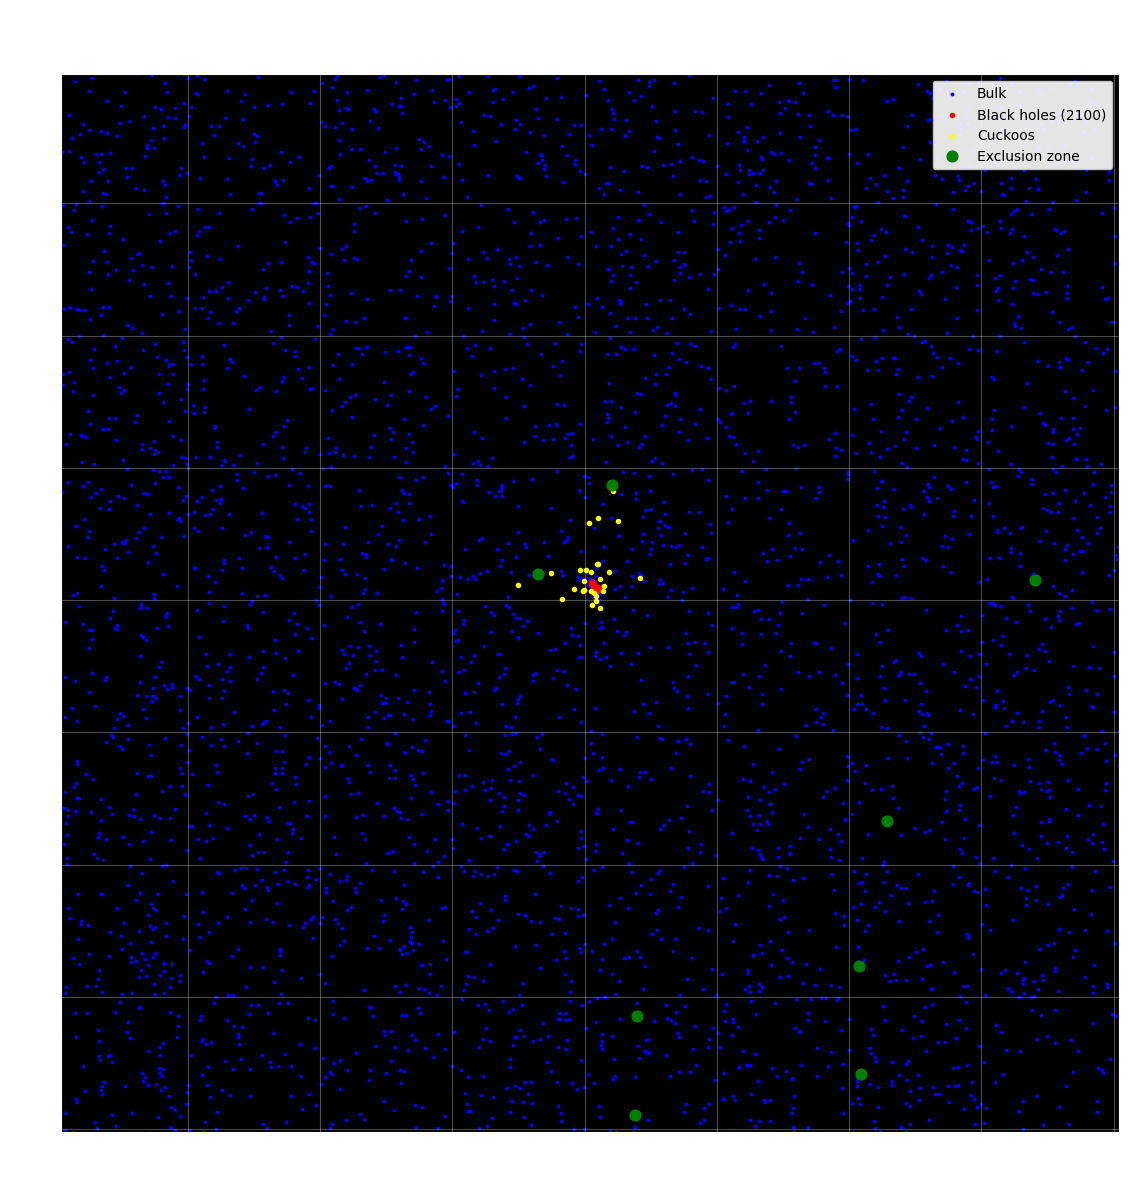


Sky map complete!
  Plotted 2,100 black hole tokens
  Collapsed to 13 unique pixels


In [22]:
print("\nCreating sky map...")

# Convert to numpy float32 for plotting
phi_np = phi_rotated.cpu().float().numpy()
theta_flat_np = theta_flat.cpu().float().numpy()
black_hole_np = black_hole_mask.cpu().numpy()
cuckoo_np = cuckoo_mask.cpu().numpy()
exclusion_np = exclusion_mask.cpu().numpy()
bulk_np = bulk_mask.cpu().numpy()

# Create figure
fig, ax = plt.subplots(figsize=(12, 12), dpi=FIGURE_DPI)
ax.set_facecolor('black')

# Plot in layers
ax.scatter(phi_np[bulk_np], theta_flat_np[bulk_np],
           s=POINT_SIZE, alpha=POINT_ALPHA, c='blue', label='Bulk', rasterized=True)

ax.scatter(phi_np[black_hole_np], theta_flat_np[black_hole_np],
           s=POINT_SIZE*3, alpha=POINT_ALPHA, c='red', label=f'Black holes ({n_black_holes})', rasterized=True)

ax.scatter(phi_np[cuckoo_np], theta_flat_np[cuckoo_np],
           s=POINT_SIZE*3, alpha=POINT_ALPHA, c='yellow', label='Cuckoos', rasterized=True)

ax.scatter(phi_np[exclusion_np], theta_flat_np[exclusion_np],
           s=POINT_SIZE*20, alpha=POINT_ALPHA, c='green', label='Exclusion zone', rasterized=True)

# Set limits and grid
ax.set_xlim(lon_min, lon_max)
ax.set_ylim(lat_min, lat_max)
ax.set_aspect('equal')
ax.grid(True, alpha=0.3, color='white')

# Labels
ax.set_xlabel('Longitude (degrees)', color='white', fontsize=12)
ax.set_ylabel('Latitude (CDF-flattened, degrees)', color='white', fontsize=12)
ax.set_title(f'Sky Map in Optimal Projection (Float64)\nAngular Extent: {angular_extent:.2f} sq deg | {len(unique_coords)} unique points | {zoom_mode}',
             color='white', pad=20, fontsize=14)

# White axes and ticks
ax.tick_params(colors='white')
for spine in ax.spines.values():
    spine.set_edgecolor('white')

# Legend
legend = ax.legend(loc='upper right', framealpha=0.9, fontsize=10)
for handle in legend.legend_handles:
    handle.set_alpha(1.0)

plt.tight_layout()
plt.show()

print(f"\nSky map complete!")
print(f"  Plotted {n_black_holes:,} black hole tokens")
print(f"  Collapsed to {len(unique_coords)} unique pixels")

## Summary

Using float64 intermediate computation, we eliminated numerical noise and collapsed degenerate tokens to identical coordinates.

**Goal achieved:** All 2,183 black hole tokens plotted, but only 13 visible red dots (one per unique embedding vector).

This is the true geometric structure of the black hole singularity—2,100+ tokens collapsed onto 13 points in 2560D space.